In [1]:
import pandas as pd
import altair as alt

### 0) Pull Podcast data from iTunes with Applescript/Coffeescript  
In some cases podcasts don't have the 'media type' of "Podcast," but we'll ignore those for now.

```coffeescript
tell application "iTunes"
	set trackData to "name|duration|album|artist|composer|genre|playedCount|datePlayed|dateAdded|unplayed|year|description\n"
	repeat with aTrack in tracks of library playlist 1
		set td to ""
		set td to td & name of aTrack & "|"
		set td to td & duration of aTrack & "|"
		set td to td & album of aTrack & "|"
		set td to td & artist of aTrack & "|"
		set td to td & composer of aTrack & "|"
		set td to td & genre of aTrack & "|"
		set td to td & played count of aTrack & "|"
		set td to td & played date of aTrack & "|"
		set td to td & date added of aTrack & "|"
		set td to td & unplayed of aTrack & "|"
		set td to td & year of aTrack & "|"
		set td to td & long description of aTrack & "\n"
		
		set trackData to trackData & td
	end repeat
	copy trackData to stdout
end tell
```  
  
This is run from bash with:
```bash
    osascript pullTrackData_upd101517.scpt > podcastdatapull_upd102117.txt
```

### 1) set up the result

In [2]:
raw_data = pd.read_table('data/datapull_upd102617.txt',
                         sep='|',error_bad_lines=False, warn_bad_lines=False,
                         dtype={'year':str}
                        )
print(raw_data.shape)
raw_data.head()

(10475, 13)


,name,mediaKind,duration,album,artist,composer,genre,playedCount,datePlayed,dateAdded,unplayed,year,description
0,Riots,«constant ****kMdS»,119.50700378418,Slumdog Millionaire (Music from the Motion Pic...,A. R. Rahman,A. R. Rahman,Soundtrack,0.0,missing value,"Saturday, March 7, 2009 at 20:27:41",True,2008,missing value
1,Mausam & Escape,«constant ****kMdS»,232.839996337891,Slumdog Millionaire (Music from the Motion Pic...,A. R. Rahman,A. R. Rahman,Soundtrack,0.0,missing value,"Saturday, March 7, 2009 at 20:27:41",True,2008,missing value
2,O... Saya,«constant ****kMdS»,213.826995849609,Slumdog Millionaire (Music from the Motion Pic...,A. R. Rahman & M.I.A.,A. R. Rahman,Soundtrack,0.0,missing value,"Saturday, March 7, 2009 at 20:27:41",True,2008,missing value
3,Millionaire,«constant ****kMdS»,164.427001953125,Slumdog Millionaire (Music from the Motion Pic...,A. R. Rahman & Madhumitha,A. R. Rahman,Soundtrack,0.0,missing value,"Saturday, March 7, 2009 at 20:27:41",True,2008,missing value
4,Latika's Theme,«constant ****kMdS»,189.373001098633,Slumdog Millionaire (Music from the Motion Pic...,A. R. Rahman & Suzanne,A. R. Rahman,Soundtrack,0.0,missing value,"Saturday, March 7, 2009 at 20:27:41",True,2008,missing value


### 2) Preliminary processing
- remove things with no descriprtion
- that have no played date
- that also weren't flagged as unplayed

In [3]:
podcast_data = raw_data[(raw_data['description'] != 'missing value') 
                        & (raw_data['unplayed']==False)
                        & (raw_data['datePlayed']!='missing value')].copy()
podcast_data.drop(['mediaKind','composer'],axis=1,inplace=True)
podcast_data.loc[:,'datePlayed'] = pd.core.tools.datetimes.to_datetime(podcast_data['datePlayed'])
podcast_data.loc[:,'dateAdded'] = pd.core.tools.datetimes.to_datetime(podcast_data['dateAdded'])
print(podcast_data.shape)
podcast_data.head()

(6568, 11)


,name,duration,album,artist,genre,playedCount,datePlayed,dateAdded,unplayed,year,description
10,A.D.K.O.B. - Helium,253.0,KEXP Song of the Day,A.D.K.O.B.,Podcast,1.0,2017-09-28 09:29:47,2017-09-28 06:43:37,False,2017,A.D.K.O.B. - Helium - a 2017 single on Wonderl...
11,A.D.K.O.B. - Lung Capacity,172.0,KEXP Song of the Day,A.D.K.O.B.,Podcast,1.0,2017-08-13 22:47:02,2017-01-30 06:15:32,False,0,A.D.K.O.B. - Lung Capacity - from the 2015 A D...
12,Aan - All You Have to Say,214.0,KEXP Song of the Day,Aan,Podcast,1.0,2017-01-20 11:03:50,2017-01-21 11:16:12,False,2016,Aan - All You Have to Say - from the 2016 albu...
16,Ablebody - Backseat Heart,297.0,KEXP Song of the Day,Ablebody,Podcast,1.0,2017-01-03 13:11:12,2017-01-30 06:15:32,False,0,Ablebody - Backseat Heart - from the 2016 albu...
33,Acapulco Lips,1269.0,KEXP Live Performances Podcast,Acapulco Lips,Podcast,1.0,2017-01-01 08:03:15,2017-01-30 06:14:26,False,0,"Maria-Elena Juarez, Christopher Garland, and D..."


### 3) Initial generated fields
These will help with categorizations in data exploration

In [4]:
# 3.1) What was the listen day?
podcast_data['dateAdded_DoW'] = podcast_data['dateAdded'].dt.strftime('%a')
podcast_data['datePlayed_DoW'] = podcast_data['datePlayed'].dt.strftime('%a')

In [5]:
# 3.2) What part of the day was it consumed?
def bin_f(x):
    h = pd.datetime.time(x).hour
    if h < 6:
        return "em" #early morning
    elif h < 12:
        return "m" # morning
    elif h < 18:
        return "a" # afternoon
    else:
        return "e" # evening
    
podcast_data['dateAdded_Part'] = podcast_data['dateAdded'].apply(lambda i: bin_f(i))
podcast_data['datePlayed_Part'] = podcast_data['datePlayed'].apply(lambda i: bin_f(i))

In [6]:
# 3.3 How many seconds were there since adding the podcast?
# negative values indicate an error in syncing, or a new podcast subsciption
podcast_data['downloadToPlay_Seconds'] = (podcast_data['datePlayed'] - podcast_data['dateAdded']).dt.total_seconds()

# add error indicator, this is a catch-all
podcast_data['syncSubError_Ind'] = podcast_data['downloadToPlay_Seconds'] < 0

In [7]:
# 3.4 Was it played in the same day?
podcast_data['playedSameDay_Ind'] = ((podcast_data['dateAdded_DoW'] == podcast_data['datePlayed_DoW'])\
                                    & (podcast_data['downloadToPlay_Seconds'] < 86400)\
                                    & (podcast_data['downloadToPlay_Seconds'] >= 0)
                                    )

In [8]:
podcast_data.head()

,name,duration,album,artist,genre,playedCount,datePlayed,dateAdded,unplayed,year,description,dateAdded_DoW,datePlayed_DoW,dateAdded_Part,datePlayed_Part,downloadToPlay_Seconds,syncSubError_Ind,playedSameDay_Ind
10,A.D.K.O.B. - Helium,253.0,KEXP Song of the Day,A.D.K.O.B.,Podcast,1.0,2017-09-28 09:29:47,2017-09-28 06:43:37,False,2017,A.D.K.O.B. - Helium - a 2017 single on Wonderl...,Thu,Thu,m,m,9970.0,False,True
11,A.D.K.O.B. - Lung Capacity,172.0,KEXP Song of the Day,A.D.K.O.B.,Podcast,1.0,2017-08-13 22:47:02,2017-01-30 06:15:32,False,0,A.D.K.O.B. - Lung Capacity - from the 2015 A D...,Mon,Sun,m,e,16907490.0,False,False
12,Aan - All You Have to Say,214.0,KEXP Song of the Day,Aan,Podcast,1.0,2017-01-20 11:03:50,2017-01-21 11:16:12,False,2016,Aan - All You Have to Say - from the 2016 albu...,Sat,Fri,m,m,-87142.0,True,False
16,Ablebody - Backseat Heart,297.0,KEXP Song of the Day,Ablebody,Podcast,1.0,2017-01-03 13:11:12,2017-01-30 06:15:32,False,0,Ablebody - Backseat Heart - from the 2016 albu...,Mon,Tue,m,a,-2307860.0,True,False
33,Acapulco Lips,1269.0,KEXP Live Performances Podcast,Acapulco Lips,Podcast,1.0,2017-01-01 08:03:15,2017-01-30 06:14:26,False,0,"Maria-Elena Juarez, Christopher Garland, and D...",Mon,Sun,m,m,-2499071.0,True,False


### 4) Generate summary based on the current data  
Let's start with a basic question - <b><i>when are most podcasts played?<i><b>

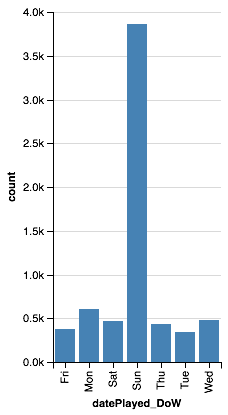

In [16]:
# summarize data overall by played day of week and see if there are any patterns
played_summary = podcast_data[['datePlayed_DoW','name']].groupby(['datePlayed_DoW']).count().reset_index()
played_summary.rename(columns={'name':'count'},inplace=True)
alt.Chart(played_summary
         ).mark_bar().encode(
    x='datePlayed_DoW',
    y='count'
)

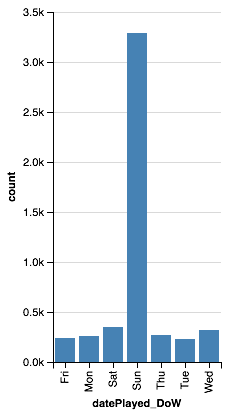

In [10]:
# What happens when we remove the instances with sync or subscription errors flagged?
podcast_data_noSSError = podcast_data[podcast_data['syncSubError_Ind']==False]
played_summary_noSSError = podcast_data_noSSError[['datePlayed_DoW','name']].groupby(['datePlayed_DoW']).count().reset_index()
played_summary_noSSError.rename(columns={'name':'count'},inplace=True)
alt.Chart(played_summary_noSSError
         ).mark_bar().encode(
    x='datePlayed_DoW',
    y='count'
)

It looks like there's still a spike on Sunday, so why is that? I expect the following explainations to apply:  
- It doesn't interest me and I for some reason feel that I'll have time to passively consume it   
- I've put off listening to it for a while (at least a week)  
- I've just added the podcast, and don't want to go through the backlog/see it in my feed  
  
That leads to the following question - <b><i>what is the breakdown of the volume that was played on Sunday?<b><i>

In [11]:
# summarize data with no time error by day played, added, and podcast name
played_summary_by_podcast = podcast_data_noSSError[['datePlayed_DoW','dateAdded_DoW','name','dateAdded_Part','datePlayed_Part','album']]\
    .groupby(['datePlayed_DoW','dateAdded_DoW','dateAdded_Part','datePlayed_Part','album']).count().reset_index()
played_summary_by_podcast.rename(columns={'name':'count'},inplace=True)

# Isolate just the Sunday data
sundayPodcastData = played_summary_by_podcast[played_summary_by_podcast['datePlayed_DoW']=='Sun']
sundayPodcastData_agg = sundayPodcastData[['album','count']].groupby('album').sum().reset_index()
sundayPodcastData_agg.sort_values('count',ascending=False).head(10)

,album,count
23,KEXP Song of the Day,373
45,Savage Lovecast,259
42,RISK!,253
41,Pop Culture Happy Hour,247
1,99% Invisible,241
3,All Songs Considered,231
36,Planet Money,224
22,KEXP Presents Music That Matters,209
13,Freakonomics Radio,202
51,Spilled Milk,190


Looking at the top ten podcasts played on Sunday, I would guess that I either delay playing these, or when I set up iTunes on this machine, I marked lots of episodes of this podcast as played. For some like Savage Lovecast and RISK!, that I'm less likely to listen to right away, I backlog those through the week and listen to them while doing things around the house. To capture this, I'll only consider podcasts that were listened to after the date I added KEXP Song of the Day podcast.

In [12]:
dupAdded = list((podcast_data['dateAdded'].value_counts() > 5).index)
dupPlayed = list((podcast_data['datePlayed'].value_counts() > 5).index)

In [13]:
podcast_data['dupDate'] = (~podcast_data['dateAdded'].isin(dupAdded)) | (~podcast_data['datePlayed'].isin(dupPlayed))

In [14]:
podcast_data[podcast_data['dupDate']==False].head()

,name,duration,album,artist,genre,playedCount,datePlayed,dateAdded,unplayed,year,description,dateAdded_DoW,datePlayed_DoW,dateAdded_Part,datePlayed_Part,downloadToPlay_Seconds,syncSubError_Ind,playedSameDay_Ind,dupDate
10,A.D.K.O.B. - Helium,253.0,KEXP Song of the Day,A.D.K.O.B.,Podcast,1.0,2017-09-28 09:29:47,2017-09-28 06:43:37,False,2017,A.D.K.O.B. - Helium - a 2017 single on Wonderl...,Thu,Thu,m,m,9970.0,False,True,False
11,A.D.K.O.B. - Lung Capacity,172.0,KEXP Song of the Day,A.D.K.O.B.,Podcast,1.0,2017-08-13 22:47:02,2017-01-30 06:15:32,False,0,A.D.K.O.B. - Lung Capacity - from the 2015 A D...,Mon,Sun,m,e,16907490.0,False,False,False
12,Aan - All You Have to Say,214.0,KEXP Song of the Day,Aan,Podcast,1.0,2017-01-20 11:03:50,2017-01-21 11:16:12,False,2016,Aan - All You Have to Say - from the 2016 albu...,Sat,Fri,m,m,-87142.0,True,False,False
16,Ablebody - Backseat Heart,297.0,KEXP Song of the Day,Ablebody,Podcast,1.0,2017-01-03 13:11:12,2017-01-30 06:15:32,False,0,Ablebody - Backseat Heart - from the 2016 albu...,Mon,Tue,m,a,-2307860.0,True,False,False
33,Acapulco Lips,1269.0,KEXP Live Performances Podcast,Acapulco Lips,Podcast,1.0,2017-01-01 08:03:15,2017-01-30 06:14:26,False,0,"Maria-Elena Juarez, Christopher Garland, and D...",Mon,Sun,m,m,-2499071.0,True,False,False


In [15]:
x = podcast_data[['datePlayed','dateAdded_DoW']].groupby('datePlayed').count().reset_index()
podcast_data['batchPlay_Ind'] = x['dateAdded_DoW'].astype(int)>1
podcast_data[podcast_data['batchPlay_Ind']==False].groupby('datePlayed').count().reset_index()

,datePlayed,name,duration,album,artist,genre,playedCount,dateAdded,unplayed,year,description,dateAdded_DoW,datePlayed_DoW,dateAdded_Part,datePlayed_Part,downloadToPlay_Seconds,syncSubError_Ind,playedSameDay_Ind,dupDate,batchPlay_Ind
0,2016-09-19 14:17:55,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,2016-09-19 21:47:46,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180
2,2016-09-19 21:48:07,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14
3,2016-09-20 08:03:55,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,2016-09-21 12:55:35,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,2016-09-22 10:55:45,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,2016-09-26 12:30:37,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,2016-09-27 07:59:03,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
8,2016-09-28 13:22:23,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
9,2016-09-29 15:46:06,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
